# Web Scraping for Reddit & Predicting Comments

In this project, we will practice two major skills. Collecting data by scraping a website and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results

In [4]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk

In [5]:
url = "http://www.reddit.com"
response=requests.get(url)#establishing connection and setting a request
print(response.status_code)
html=response.text
soup = BeautifulSoup(html, 'lxml')

429


While this has some more verbose elements removed, we can see that there is some structure to the above:
- The thread title is within an `<a>` tag with the attribute `data-event-action="title"`.
- The time since the thread was created is within a `<time>` tag with attribute `class="live-timestamp"`.
- The subreddit is within an `<a>` tag with the attribute `class="subreddit hover may-blank"`.
- The number of comments is within an `<a>` tag with the attribute data-event-action="comments"`.

## Write 4 functions to extract these items (one function for each): title, time, subreddit, and number of comments.¶
Example
```python
def extract_title_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

In [438]:
## YOUR CODE HERE
def extract_title_from_result(result):
    a=result.find('a',{'class':"title may-blank outbound"})
    return a.text if a else None
        

In [439]:
## YOUR CODE HERE
def extract_submitted_from_result(result):
    a=result.find('time',{'class':"live-timestamp"})
    return a.text if a else None
        

In [440]:
## YOUR CODE HERE
def extract_comments_from_result(result):
    a=result.find('a',{'class':"bylink comments may-blank"})
    return a.text if a else None
         

In [441]:
## YOUR CODE HERE
def extract_subreddit_from_result(result):
    a=result.find('a',{'class':"subreddit hover may-blank"})
    return a.text if a else None

Now, to scale up our scraping, we need to accumulate more results.

First, look at the source of a Reddit.com page: (https://www.reddit.com/).
Try manually changing the page by clicking the 'next' button on the bottom. Look at how the url changes.

After leaving the Reddit homepage, the URLs should look something like this:
```
https://www.reddit.com/?count=25&after=t3_787ptc
```

The URL here has two query parameters
- count is the result number that the page starts with
- after is the unique id of the last result on the _previous_ page

In order to scrape lots of pages from Reddit, we'll have to change these parameters every time we make a new request so that we're not just scraping the same page over and over again. Incrementing the count by 25 every time will be easy, but the bizarre code after `after` is a bit trickier.

To start off, let's look at a block of HTML from a Reddit page to see how we might solve this problem:
```html
<div class=" thing id-t3_788tye odd gilded link " data-author="LordSneaux" data-author-fullname="t2_j3pty" data-comments-count="1548" data-context="listing" data-domain="v.redd.it" data-fullname="t3_788tye" data-kind="video" data-num-crossposts="0" data-permalink="/r/funny/comments/788tye/not_all_heroes_wear_capes/" data-rank="25" data-score="51468" data-subreddit="funny" data-subreddit-fullname="t5_2qh33" data-timestamp="1508775581000" data-type="link" data-url="https://v.redd.it/ush0rh2tultz" data-whitelist-status="all_ads" id="thing_t3_788tye" onclick="click_thing(this)">
      <p class="parent">
      </p>
      <span class="rank">
       25
      </span>
      <div class="midcol unvoted">
       <div aria-label="upvote" class="arrow up login-required access-required" data-event-action="upvote" role="button" tabindex="0">
       </div>
       <div class="score dislikes" title="53288">
        53.3k
       </div>
       <div class="score unvoted" title="53289">
        53.3k
       </div>
       <div class="score likes" title="53290">
        53.3k
       </div>
       <div aria-label="downvote" class="arrow down login-required access-required" data-event-action="downvote" role="button" tabindex="0">
       </div>
      </div>
```

Notice that within the `div` tag there is an attribute called `id` and it is set to `"thing_t3_788tye"`. By finding the last ID on your scraped page, you can tell your _next_ request where to start (pass everything after "thing_").

For more info on this, you can take a look at the [Reddit API docs](https://github.com/reddit/reddit/wiki/JSON)

## Write one more function that finds the last `id` on the page, and stores it.

In [1]:
def get_next_url(result):
    x=result.find('span',{'class':"next-button"})
    return x.find('a').get("href")

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [2]:
## YOUR CODE HERE

## Now, let's put it all together.

Use the functions you wrote above to parse out the 4 fields - title, time, subreddit, and number of comments. Create a dataframe from the results with those 4 columns.

In [ ]:
import time
max_resluts=1000
counter = 0
url="http://www.reddit.com"
data={'title':[],'submitted':[],'comments':[],'subreddit':[]}
for n in range(0,max_resluts):
    response=requests.get(url)
#     print(response.status_code)
    if response.status_code==200:    
        html=response.text
        soup = BeautifulSoup(html,'lxml')        
        for item in soup.find_all('div',{'class':"top-matter"}):
            data['title'].append(extract_title_from_result(item) )
            data['submitted'].append(extract_submitted_from_result(item) )
            data['comments'].append(extract_comments_from_result(item) )
            data['subreddit'].append(extract_subreddit_from_result(item))
        
        url=get_next_url(soup)
        if(len(data['title'])%100  == 0):
            print('now have',len(data['title']),'rows')
    else:
        if(counter % 10 == 0):
            print(counter,'failed attempts')
        counter += 1
    time.sleep(3) 

In [ ]:
dataset=pd.DataFrame(data)
dataset.head(8)

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [ ]:
# Export to csv
import os
file_path='C:\\Users\\moisessalazar77\\Desktop\\projectpics\\proj3'
dataset.to_csv(os.path.join(file_path,'redditscrap5.csv'),encoding='utf-8-sig',index=False)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [138]:
from sklearn.model_selection import train_test_split

In [455]:
## YOUR CODE HERE
import pandas as pd
file_path='C:\\Users\\moisessalazar77\\Desktop\\projectpics\\proj3\\redditscrap6.csv'
dataset=pd.read_csv(file_path)

In [456]:
dataset.head(3)

,comments,submitted,subreddit,title,mad hot,subreddit_lb,eng_feat1,eng_feat2,eng_feat3
0,947.0,3.0,r/evilbuildings,"The Unabomber’s cabin, held in an FBI storage ...",1,199.0,0,0,0
1,551.0,3.0,r/worldnews,McDonald's plans to drop foam packaging global...,1,327.0,0,0,0
2,1444.0,3.0,r/pics,"In a Berlin metro. The text reads, ""This text ...",1,266.0,0,0,0


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [457]:
dataset.drop_duplicates()

,comments,submitted,subreddit,title,mad hot,subreddit_lb,eng_feat1,eng_feat2,eng_feat3
0,947.0,3.0,r/evilbuildings,"The Unabomber’s cabin, held in an FBI storage ...",1,199.0,0,0,0
1,551.0,3.0,r/worldnews,McDonald's plans to drop foam packaging global...,1,327.0,0,0,0
2,1444.0,3.0,r/pics,"In a Berlin metro. The text reads, ""This text ...",1,266.0,0,0,0
3,833.0,2.0,r/news,All of West Virginia's public schools are clos...,1,246.0,0,1,0
4,2099.0,4.0,r/movies,"Brendan Fraser on His Comeback, Disappearance,...",1,243.0,0,0,0
5,247.0,4.0,r/OSHA,You can do anything on your last day,1,109.0,1,0,0
6,230.0,3.0,r/meirl,NaN,1,237.0,0,0,0
7,1223.0,4.0,r/PoliticalHumor,NaN,1,121.0,0,0,0
8,1897.0,5.0,r/technology,"Man removes feds’ spy cam, they demand it back...",1,302.0,0,0,0
9,162.0,2.0,r/ProgrammerHumor,FrontEnd VS BackEnd,1,123.0,0,0,0


In [458]:
dataset['subreddit']=dataset['subreddit'].astype(str)
dataset['subreddit']=dataset['subreddit'].apply(lambda x:str(x))

In [459]:
dataset.dtypes

comments        float64
submitted       float64
subreddit        object
title            object
mad hot           int64
subreddit_lb    float64
eng_feat1         int64
eng_feat2         int64
eng_feat3         int64
dtype: object

comments          0
submitted         0
subreddit         0
title           441
mad hot           0
subreddit_lb      0
eng_feat1         0
eng_feat2         0
eng_feat3         0
dtype: int64


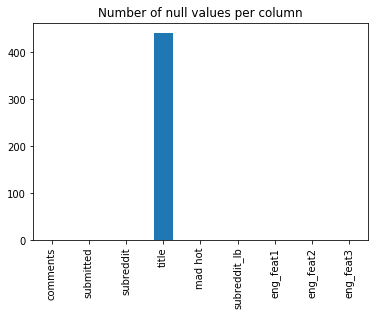

In [460]:
import matplotlib.pyplot as plt
print((dataset.isnull().sum()))
dataset.isnull().sum().plot(kind='bar');         
plt.title('Number of null values per column');
plt.show()

In [461]:
dataset['comments'].describe()

count     888.000000
mean      262.718468
std       634.909879
min         1.000000
25%        32.000000
50%        84.000000
75%       232.000000
max      9129.000000
Name: comments, dtype: float64

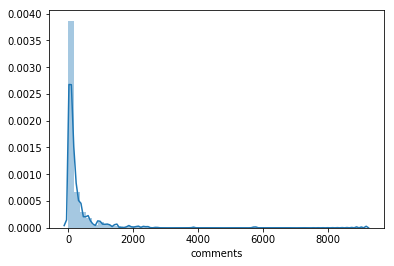

In [462]:
import seaborn as sns
sns.distplot(dataset['comments'])
plt.show()

In [463]:
from scipy import stats
print('hmean:',stats.hmean(dataset['comments']))
print('gmean:',stats.gmean(dataset['comments']))
print('mean:',dataset['comments'].mean())
print('median:',dataset['comments'].median())

hmean: 36.27084935172311
gmean: 90.02494488598114
mean: 262.7184684684685
median: 84.0


I choose the geometric mean since it would not change significatlly with the data size

In [464]:
dataset['mad hot']=(dataset['comments']>=stats.gmean(dataset['comments'])).astype(int)

In [465]:
dataset['submitted']=dataset['submitted'].apply(lambda x:float(x))
dataset['subreddit_lb']=dataset['subreddit_lb'].apply(lambda x:float(x))
dataset['mad hot']=dataset['mad hot'].apply(lambda x:int(x))

In [466]:
bool=(dataset['submitted']>21)& (dataset['comments']<1)

In [467]:
dataset.drop(dataset[bool].index,inplace=True)#droppin out liners

In [468]:
dataset.head(10)

,comments,submitted,subreddit,title,mad hot,subreddit_lb,eng_feat1,eng_feat2,eng_feat3
0,947.0,3.0,r/evilbuildings,"The Unabomber’s cabin, held in an FBI storage ...",1,199.0,0,0,0
1,551.0,3.0,r/worldnews,McDonald's plans to drop foam packaging global...,1,327.0,0,0,0
2,1444.0,3.0,r/pics,"In a Berlin metro. The text reads, ""This text ...",1,266.0,0,0,0
3,833.0,2.0,r/news,All of West Virginia's public schools are clos...,1,246.0,0,1,0
4,2099.0,4.0,r/movies,"Brendan Fraser on His Comeback, Disappearance,...",1,243.0,0,0,0
5,247.0,4.0,r/OSHA,You can do anything on your last day,1,109.0,1,0,0
6,230.0,3.0,r/meirl,NaN,1,237.0,0,0,0
7,1223.0,4.0,r/PoliticalHumor,NaN,1,121.0,0,0,0
8,1897.0,5.0,r/technology,"Man removes feds’ spy cam, they demand it back...",1,302.0,0,0,0
9,162.0,2.0,r/ProgrammerHumor,FrontEnd VS BackEnd,1,123.0,0,0,0


In [469]:
dataset.dtypes

comments        float64
submitted       float64
subreddit        object
title            object
mad hot           int64
subreddit_lb    float64
eng_feat1         int64
eng_feat2         int64
eng_feat3         int64
dtype: object

In [470]:
#function to compare both models

def evaluate_model(cm1,cm2):
    a=(cm1[0][0]+cm1[1][1])/float(cm1[0][0]+cm1[0][1]+cm1[1][0]+cm1[1][1])
    b=(cm2[0][0]+cm2[1][1])/float(cm2[0][0]+cm2[0][1]+cm2[1][0]+cm2[1][1])
    c=(cm1[0][0])/float(cm1[0][0]+cm1[1][0])
    d=(cm2[0][0])/float(cm2[0][0]+cm2[1][0])
    e=(cm1[1][1])/float(cm1[0][1]+cm1[1][1])
    f=(cm2[1][1])/float(cm2[0][1]+cm2[1][1])
    print('Model 1 Accuracy is',a)
    print('Model 2 Accuracy is',b)
    print('Model 1 sensitivity is',c)
    print('Model 2 sensitivity is',d)
    print('Model 1 Specificity is',e)
    print('Model 2 Specificity is',f)  
    df1 = pd.DataFrame(dict(graph=['Accuracy', 'Sensitivity', 'Specificity'],
                           n=[a, c, e], m=[b, d, f])) 
    
    ind = np.arange(len(df1))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(ind, df1.n, width, color='red', label='Model 1',xerr=(0.07*df1.n))
    ax.barh(ind + width, df1.m, width, color='green', label='Model 2',xerr=(0.07*df1.m))

    ax.set(yticks=ind + width, yticklabels=df1.graph, ylim=[2*width - 1, len(df1)])
    ax.legend()

    plt.show()
    column_names=['Metric','Model 2','Model 1']
    df1.columns=column_names
    
    return df1

#### Thought experiment: What is the baseline accuracy for this model?

In [471]:
baseline = 1 - dataset['mad hot'].mean()
baseline

0.5281531531531531

In [472]:
from sklearn.cross_validation import cross_val_score

def print_accuracy_report(classifier, X, y, num_validations=5):
    print('Baseline:'+ str(round(100*baseline, 2)) + "%")
    accuracy = cross_val_score(classifier, 
            X, y, scoring='accuracy', cv=num_validations)
    print("Accuracy: " + str(round(100*accuracy.mean(), 2)) + "%")

    f1 = cross_val_score(classifier, 
            X, y, scoring='f1_weighted', cv=num_validations)
    print("F1: " + str(round(100*f1.mean(), 2)) + "%")

    precision = cross_val_score(classifier, 
            X, y, scoring='precision_weighted', cv=num_validations)
    print("Precision: " + str(round(100*precision.mean(), 2)) + "%")

    recall = cross_val_score(classifier, 
            X, y, scoring='recall_weighted', cv=num_validations)
    print("Specificity: " + str(round(100*recall.mean(), 2)) + "%")


#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

With Subreddit only

In [523]:
y1=dataset['mad hot']
X1=dataset['submitted'].to_frame()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.2,random_state=42,stratify=y)

forest1=RandomForestClassifier()

forest1.fit(X_train1,y_train1 )
from sklearn.cross_validation import cross_val_score
print_accuracy_report(forest1,X_train1,y_train1, num_validations=5)

In [474]:
cs_para ={'n_estimators':[1,2,3,4,5,6,7,8,9,10], 
          'criterion':['gini','entropy'],
          'max_depth':[3,4,5,6,7,8,9,10],          
          'min_impurity_decrease':[0.0,0.001,0.01,0.1,0.4]}   



from sklearn.grid_search import GridSearchCV

clforest1 = GridSearchCV(forest1,cs_para, cv=7)
clforest1.fit(X_train1,y_train1)
clforest1=clforest1.best_estimator_

In [475]:
y_pred_1=clforest1.predict(X_test1)
from sklearn.metrics import accuracy_score
print('baseline', baseline)
print('accuracy score', accuracy_score(y_test1,y_pred_1))
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(y_test1,y_pred_1)
print(cm1)

baseline 0.5281531531531531
accuracy score 0.7078651685393258
[[87  7]
 [45 39]]


Now with both features

In [476]:
X2=dataset.iloc[:,[1,5]].values
y2=dataset.iloc[:,4].values
forest2=RandomForestClassifier()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2,random_state=42)

forest2.fit(X_train2,y_train2)
from sklearn.cross_validation import cross_val_score
print_accuracy_report(forest1,X_train2,y_train2,num_validations=5)

Baseline:52.82%
Accuracy: 77.06%
F1: 74.49%
Precision: 74.51%
Specificity: 76.49%


In [477]:
cs_para ={'n_estimators':[1,2,3,4,5,6,7,8,9,10], 
          'criterion':['gini','entropy'],
          'max_depth':[3,4,5,6,7,8,9,10],          
          'min_impurity_decrease':[0.0,0.001,0.01,0.1,0.4]}                  


clforest2 = GridSearchCV(forest2,cs_para, cv=7)
clforest2.fit(X_train2,y_train2)
clforest2=clforest2.best_estimator_

In [478]:
y_pred_2=clforest2.predict(X_test2)
from sklearn.metrics import accuracy_score
print('baseline', baseline)
print('accuracy score', accuracy_score(y_test2,y_pred_2))
from sklearn.metrics import confusion_matrix
cm2=confusion_matrix(y_test2,y_pred_2)
print(cm2)

baseline 0.5281531531531531
accuracy score 0.8146067415730337
[[87 11]
 [22 58]]


Accuracy score was much higher than baseline i both models but the latter one has a much higher accuracy,
See chart below:

Model 1 Accuracy is 0.7078651685393258
Model 2 Accuracy is 0.8146067415730337
Model 1 sensitivity is 0.6590909090909091
Model 2 sensitivity is 0.7981651376146789
Model 1 Specificity is 0.8478260869565217
Model 2 Specificity is 0.8405797101449275


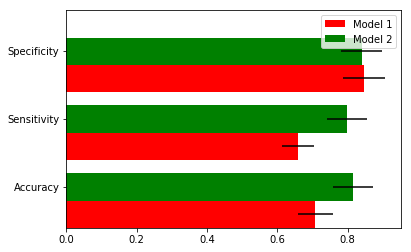

,Metric,Model 2,Model 1
0,Accuracy,0.814607,0.707865
1,Sensitivity,0.798165,0.659091
2,Specificity,0.840580,0.847826


In [479]:
evaluate_model(cm1,cm2)

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

I "googled" some popular topic in the web and used those to build the features

In [491]:
dataset

,comments,submitted,subreddit,title,mad hot,subreddit_lb,eng_feat1,eng_feat2,eng_feat3,is_game,is_celebrities
0,947.0,3.0,r/evilbuildings,"The Unabomber’s cabin, held in an FBI storage ...",1,199.0,0,0,0,0,0
1,551.0,3.0,r/worldnews,McDonald's plans to drop foam packaging global...,1,327.0,0,0,0,0,0
2,1444.0,3.0,r/pics,"In a Berlin metro. The text reads, ""This text ...",1,266.0,0,0,0,0,0
3,833.0,2.0,r/news,All of West Virginia's public schools are clos...,1,246.0,0,1,0,0,0
4,2099.0,4.0,r/movies,"Brendan Fraser on His Comeback, Disappearance,...",1,243.0,0,0,0,0,0
5,247.0,4.0,r/OSHA,You can do anything on your last day,1,109.0,1,0,0,0,0
6,230.0,3.0,r/meirl,,1,237.0,0,0,0,0,0
7,1223.0,4.0,r/PoliticalHumor,,1,121.0,0,0,0,0,0
8,1897.0,5.0,r/technology,"Man removes feds’ spy cam, they demand it back...",1,302.0,0,0,0,0,0
9,162.0,2.0,r/ProgrammerHumor,FrontEnd VS BackEnd,1,123.0,0,0,0,0,0


In [492]:
dataset['title']=dataset.title.fillna('')

In [493]:
dataset['title']=dataset['title'].astype(str)

In [494]:
dataset['is_game']= dataset['title'].map(lambda x:'game' in x).astype(int)

In [495]:
dataset['is_celebrities']= dataset['title'].map(lambda x:'celebrities' in x).astype(int)

In [497]:
dataset['is_sports']= dataset['title'].map(lambda x:'sports' in x).astype(int)

Lets try that new features

In [498]:
col=['submitted','subreddit_lb','is_game', 'is_celebrities', 'is_sports']
X3=dataset[col]       
X3=X3.values    
y3=dataset.iloc[:,4].values

In [499]:
forest3=RandomForestClassifier()
         
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size=0.2,random_state=42)

forest3.fit(X_train3,y_train3)
from sklearn.cross_validation import cross_val_score
print_accuracy_report(forest3,X_train3,y_train3,num_validations=5)

Baseline:52.82%
Accuracy: 75.92%
F1: 77.02%
Precision: 76.4%
Specificity: 75.78%


In [500]:
cs_para ={'n_estimators':[1,2,3,4,5,6,7,8,9,10], 
          'criterion':['gini','entropy'],
          'max_depth':[3,4,5,6,7,8,9,10],          
          'min_impurity_decrease':[0.0,0.001,0.01,0.1,0.4]}                  


clforest3 = GridSearchCV(forest3,cs_para, cv=7)
clforest3.fit(X_train3,y_train3)
clforest3=clforest3.best_estimator_

In [501]:
y_pred_3=clforest3.predict(X_test3)
from sklearn.metrics import accuracy_score
print('baseline', baseline)
print('accuracy score', accuracy_score(y_test3,y_pred_3))
from sklearn.metrics import confusion_matrix
cm3=confusion_matrix(y_test3,y_pred_3)
print(cm3)

baseline 0.5281531531531531
accuracy score 0.8146067415730337
[[82 16]
 [17 63]]


In [502]:
forest3.feature_importances_ 

array([0.30813113, 0.68702851, 0.00378796, 0.        , 0.00105239])

The celebreties tag seem to be unimportant!, the other ones can be keep even if they are low in importance

Now lets try the NLP 

In [503]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
cvec = CountVectorizer(analyzer ='word',stop_words='english')

In [504]:
cvec.fit(dataset['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [505]:
cvec.vocabulary_ 

{'unabomber': 1181,
 'cabin': 170,
 'held': 515,
 'fbi': 400,
 'storage': 1075,
 'facility': 386,
 'airforce': 55,
 'base': 113,
 'sacramento': 962,
 'mcdonald': 674,
 'plans': 833,
 'drop': 332,
 'foam': 424,
 'packaging': 789,
 'globally': 466,
 '2019': 17,
 'switch': 1105,
 'recycled': 913,
 'materials': 672,
 'location': 640,
 '2020': 18,
 'berlin': 126,
 'metro': 689,
 'text': 1123,
 'reads': 906,
 'purpose': 886,
 'terrify': 1121,
 'afraid': 51,
 'arabic': 82,
 'language': 606,
 'west': 1236,
 'virginia': 1210,
 'public': 880,
 'schools': 975,
 'closed': 223,
 'teacher': 1115,
 'walk': 1220,
 'pay': 807,
 'brendan': 154,
 'fraser': 437,
 'comeback': 230,
 'disappearance': 309,
 'experience': 378,
 'nearly': 732,
 'ended': 352,
 'career': 181,
 'day': 277,
 'man': 661,
 'removes': 927,
 'feds': 403,
 'spy': 1051,
 'cam': 173,
 'demand': 284,
 'refuses': 919,
 'sues': 1087,
 'frontend': 444,
 'vs': 1216,
 'backend': 103,
 'sea': 983,
 'turtle': 1173,
 'swimming': 1104,
 'nap': 725,

In [506]:
cvecdata = cvec.transform(dataset['title'])

In [507]:
df  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

In [508]:
common_word=[]
col=df.columns
for i in col:
    try:
        common_word.append((i,df[i].sum()))
    except:
        common_word.append((None,None))

In [509]:
df2=pd.DataFrame(common_word)

In [510]:
lsta1=['word','freq']
df2.columns=lsta1

In [511]:
df2.sort_values('freq',ascending=False).head(10)

,word,freq
277,day,16
974,school,12
1162,trump,11
1255,world,11
488,gun,10
999,shooting,9
518,hero,9
260,country,9
475,got,9
834,plastic,8


In [512]:
dataset['is_day']= dataset['title'].map(lambda x:'day' in x).astype(int)

In [513]:
dataset['school']= dataset['title'].apply(lambda x:'school' in x).astype(int)

In [514]:
dataset['trump']= dataset['title'].apply(lambda x:'trump' in x).astype(int)

Model with subreddit and new features

In [515]:
col2=['submitted','subreddit_lb', 
     'is_game','is_sports','is_day', 'school', 
     'trump']
X4=dataset[col2]

In [516]:
from sklearn.grid_search import GridSearchCV
X4=X4.values
y4=dataset.iloc[:,4].values

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,y4,test_size=0.2,random_state=42)

forest4=RandomForestClassifier()

In [517]:
forest4.fit(X_train4,y_train4)
from sklearn.cross_validation import cross_val_score
print_accuracy_report(forest4,X_train4,y_train4,num_validations=5)

Baseline:52.82%
Accuracy: 76.06%
F1: 76.18%
Precision: 77.64%
Specificity: 76.34%


In [518]:
cs_para ={'n_estimators':[1,2], 
          'criterion':['gini','entropy'],
          'max_depth':[3,4,5,6,7,8,9,10],          
          'min_impurity_decrease':[0.0,0.001,0.01,0.1,0.4]}                  


clforest4 = GridSearchCV(forest4,cs_para, cv=7)
clforest4.fit(X_train4,y_train4)
clforest4=clforest4.best_estimator_

In [519]:
y_pred_4=clforest4.predict(X_test4)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test4,y_pred_4))
from sklearn.metrics import confusion_matrix
cm4=confusion_matrix(y_test4,y_pred_4)
print(cm4)

0.7247191011235955
[[80 18]
 [31 49]]


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [520]:
forest4.fit(X_train4,y_train4)
from sklearn.cross_validation import cross_val_score
print_accuracy_report(forest4,X_train4,y_train4,num_validations=5)

Baseline:52.82%
Accuracy: 77.19%
F1: 77.16%
Precision: 76.43%
Specificity: 76.9%


The inclusion of new features seem to be slightly detrimental and subject to some variance

In [521]:
clforest4.feature_importances_

array([4.63415073e-01, 4.88849258e-01, 1.18122695e-02, 4.60615231e-04,
       1.17767219e-02, 2.36860625e-02, 0.00000000e+00])

It seem that the inclusion of low importance features was detrimental

#### Repeat the model-building process with a non-tree-based method.

In [ ]:
col3=['submitted','subreddit_lb','school']
X5=dataset[col3]

In [ ]:
from sklearn.cross_validation import train_test_split
X5=X5.values
y5=dataset.iloc[:,4]
X_train5,X_test5,y_train5,y_test5=train_test_split(X5,y5,test_size=0.2,random_state=42)
from sklearn.model_selection import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logreg = GridSearchCV(LogisticRegression(penalty='l2',random_state=42), param_grid)
GridSearchCV(cv=sss,
             estimator=LogisticRegression(C=0.001, intercept_scaling=1,random_state=42, 
               dual=False, fit_intercept=True, penalty='l2', tol=0.00001,n_jobs=-1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
logreg.fit(X_train5,y_train5)

In [ ]:
logreg.best_estimator_

In [ ]:
logreg=logreg.fit(X_train5,y_train5)
y_pred_5=logreg.predict(X_test5)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_test5,y_pred_5))
cm5=confusion_matrix(y_test5,y_pred_5)
print(cm5)

In [ ]:
sns.lmplot(x="submitted", y="mad hot", data=dataset, logistic=True, y_jitter=.05)
plt.grid(True)
plt.show()

Just to experiment,I deceided to build a GLM model and a linear regression model

In [ ]:
col3=['submitted','subreddit_lb','is_game', 'is_celebrities', 
      'is_sports','is_day','school','trump']
X6=dataset[col3]
y6=dataset.iloc[:,0]

In [ ]:
X6['trump']=X6['trump'].astype(int)

In [ ]:
a=X6['subreddit_lb'].mean()
b=X6['subreddit_lb'].std()
X6['subreddit_lb']=X6['subreddit_lb'].apply(lambda x:(x-a)/b)

In [ ]:
c=X6['submitted'].mean()
d=X6['submitted'].std()
X6['submitted']=X6['submitted'].apply(lambda x:(x-c)/d)

In [ ]:
e=y6.mean()
f=y6.std()
delta3=e-f
y6=y6.apply(lambda x:(x-e/f))

In [ ]:
X6.isnull().sum()


In [286]:
import numpy as np
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.2, random_state = 42)

In [374]:
from sklearn.cross_validation import train_test_split
import numpy as np
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.2, random_state = 42)
import statsmodels.api as sm
X_train6 = sm.add_constant(X_train6)
model = sm.GLM(y_train6,X_train6, family=sm.families.Gamma(link = sm.genmod.families.links.identity)).fit()

model.summary()


C:\Users\moisessalazar77\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:244: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
C:\Users\moisessalazar77\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\moisessalazar77\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\moisessalazar77\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\moisessalazar77\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               comments   No. Observations:                  710
Model:                            GLM   Df Residuals:                      703
Model Family:                   Gamma   Df Model:                            6
Link Function:               identity   Scale:               6.581113927691231
Method:                          IRLS   Log-Likelihood:                -4900.1
Date:                Sun, 25 Feb 2018   Deviance:                       1243.5
Time:                        16:06:53   Pearson chi2:                 4.63e+03
No. Iterations:                    17                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            259.4233     27.832      9.321      0.000     204.874     313.972
submitted        171.1033     32.200      5.314      0.000     107.992     234.215
subreddit_lb       8.8686     15.365      0.577      0.564     -21.245      38.983
is_game          -35.0077     85.473     -0.410      0.682    -202.532     132.516
is_celebrities  3.171e-14    3.5e-14      0.906      0.365   -3.69e-14       1e-13
is_sports       -125.2248    190.743     -0.657      0.511    -499.075     248.625
is_day           -75.5216     69.824     -1.082      0.279    -212.375      61.331
school           459.5728    659.070      0.697      0.486    -832.180    1751.325
trump                   0          0        nan        nan           0           0
==================================================================================
"""

model = sm.OLS(endog=ydat, exog=xdat).fit()

In [380]:
from sklearn.cross_validation import train_test_split
col5=['submitted','school']
X7=X6[col5].values
y7=y6.values
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size = 0.2, random_state = 42)
import statsmodels.api as sm
X_train7 = sm.add_constant(X_train7)
model = sm.GLM(y_train7,X_train7, family=sm.families.Gamma(link = sm.genmod.families.links.inverse_power)).fit()

model.summary()


C:\Users\moisessalazar77\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  710
Model:                            GLM   Df Residuals:                      707
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:               6.701697959460619
Method:                          IRLS   Log-Likelihood:                -4927.8
Date:                Sun, 25 Feb 2018   Deviance:                       1500.3
Time:                        16:10:57   Pearson chi2:                 4.74e+03
No. Iterations:                     9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.000     10.090      0.000       0.004       0.006
x1            -0.0017      0.000     -6.413      0.000      -0.002      -0.001
x2            -0.0014      0.001     -2.224      0.026      -0.003      -0.000
==============================================================================
"""

In [349]:
print('Total number of trials:',y7.sum())
print('Parameters: ', model.params)
print('T-values: ', model.tvalues)

Total number of trials: 232926.55572518538
Parameters:  const        258.663389
submitted    171.594229
school       469.533552
dtype: float64
T-values:  const        9.559475
submitted    5.434251
school       0.725245
dtype: float64


In [350]:
from sklearn.metrics import r2_score
y_pred7=model.predict(X_test7)
print(r2_score(y_test7,y_pred7))
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test7,y_pred7))

0.038802525547976585
280.00900052460463


In [351]:
 means = X_train7.mean(axis=0)


means25 = means.copy()

means25[0] = stats.scoreatpercentile(X[:, 0], 25)

means75 = means.copy()

 means75[0] = lowinc_75per = stats.scoreatpercentile(X[:, 0], 75)

resp_25 = model.predict(means25)

 resp_75 = model.predict(means75)

diff = resp_75 - resp_25


In [352]:
nobs = model.nobs

y = y_train7/(y_train7.sum())

yhat = model.mu

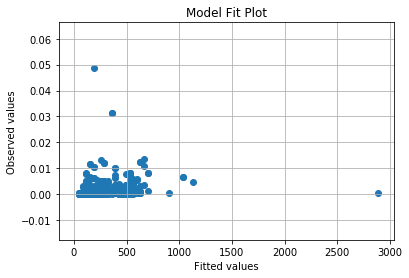

In [361]:
plt.figure();

plt.scatter(yhat, y);

line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=False)).fit().params

fit = lambda x: line_fit[1] + line_fit[0] * x  # better way in scipy?

plt.plot(np.linspace(0, 1, nobs), fit(np.linspace(0, 1, nobs)));
plt.grid(True)
plt.title('Model Fit Plot');

plt.ylabel('Observed values');

plt.xlabel('Fitted values');
plt.show()

Also I experimented with linear regression to find the following
This model has a R square is close to 4%,therefore not a very good result as a first run.

In [61]:
#fitting the multiple linear regression into the training set

from sklearn.linear_model import LinearRegression
X6=dataset.iloc[:,[1,5,6,7]].values
y6=dataset.iloc[:,0].values
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.2, random_state = 42)
regressor=LinearRegression()
regressor.fit(X_train6,y_train6)
#Predicting the test set results
y_pred_6=regressor.predict(X_test6)
#import
import statsmodels.formula.api as smf
X_train6=np.append(arr=np.ones((len(X_train6),1)).astype(int),values=X_train6,axis=1)
X_opt=X_train6
regressor_OLS=smf.OLS(endog=y_train6,exog=X_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     9.663
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           1.30e-07
Time:                        07:13:33   Log-Likelihood:                -5506.9
No. Observations:                 710   AIC:                         1.102e+04
Df Residuals:                     705   BIC:                         1.105e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.8000     53.625      0.649      0.517     -70.483     140.083
x1            22.1370      4.051      5.465      0.000      14.184      30.090
x2             0.3669      0.226      1.625      0.105      -0.076       0.810
x3          -146.3612    158.917     -0.921      0.357    -458.368     165.646
x4           473.6086    216.007      2.193      0.029      49.514     897.703
==============================================================================
Omnibus:                     1061.423   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           329129.902
Skew:                           8.387   Prob(JB):                         0.00
Kurtosis:                     107.135   Cond. No.                     1.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

## YOUR CODE HERE
-Please see code avode.

-It can be either slightly detrimental or yield a slightly 
 increased in accuracy with an also slightly increased in variance
 
-The ones extracted using NPL objects as count vectorizer.

# Executive Summary
---
Put your executive summary in a Markdown cell below.

-The need to used custome made metrics
-All models performed above baseline
-Best model accuracy around 80%

### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE